In [1]:
from pathlib import Path
import os
import time
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from model import *
from test import *


# pre-process
def pre_proc(tau, block):
    '''log(tau)'''
    tau   = np.log(tau)
    block = np.array(block)
    return (tau, block)

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau


# Path and data file name
folder  = Path.cwd().parent / 'Illustris3'
DM_name = ['DMdelta_Illustris3_L75_N600_v2.fits', 
            'vx_cic_Illustris3_L75_N600_v2.fits',
            'vy_cic_Illustris3_L75_N600_v2.fits',
            'vz_cic_Illustris3_L75_N600_v2.fits']
ske_name = 'spectra_Illustris3_N600_zaxis.npy'



# hyper parameters
train_insize = np.array([15, 15, 71]) # x, y, z respctively
train_ousize = np.array([5, 5, 5]) # x, y, z respctively
test_batch = 50
localtime_n = ['2019-11-23 03:41:42']

In [2]:
for localtime_i in localtime_n:
    localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')

    
    # device used to train the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(device=device.index))


    # load dark matter data
    print('Loading dark matter...')
    DM_general = load_DM(folder, DM_name)
    DM_general = DM_general.transpose(0,1,2,3)
    DM_general = DM_general[[0,1,2,3]]
    # basic paramters
    DM_param.pix  = len(DM_general[0])
    DM_param.len  = 75 # in Mpc/h
    DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
    # test
    if DM_general.shape[1]<train_insize.min():
        raise ValueError('DarkMatter cube size',
            DM_general.shape, 'is too small for train size', train_insize, '.')
    DM_general = torch.tensor(DM_general).float()


    # load skewers
    print('Loading skewers...')
    ske, block = load_skewers(folder, ske_name, train_ousize, DM_param)
    # basic parameters
    ske_len = int(ske.shape[-1])


    # divide the sample to training, validation set, and test set.
    print('Setting test set...')
    with open("id_seperate/id_seperate_%s.txt"\
              %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
        aa = f.readlines()
        id_seperate = np.array(list(aa[0][::3])).astype('int')
        del aa
    f.close()

    test_ske, test_block = load_test(ske, block, id_seperate,
                                     train_ousize, test_batch, pre_proc)
    del id_seperate


    # load model
    print('Loading model...')
    model = get_residual_network().float().to(device)
    model.load_state_dict(torch.load('params/params_%s.pkl'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    #model.load_state_dict(torch.load('params/HyPhy_%s'\
    #        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



    # loss
    criterion = nn.L1Loss()


    # record starr time
    start_time = time.time()


    # start test
    print('Begin testing...')
    test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                            test_batch, train_insize, model, criterion, device, start_time)

    print("Test Summary: ")
    print("\tTest loss: {}".format(test_losses))
    
    # restore test skewers
    print('Restoring test skewers...')
    nz = (ske_len/train_ousize[2]).astype('int')
    test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_outp = toF_proc(test_outp)
    test_ske  = toF_proc(test_ske)
    test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
    xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
    ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
    mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
    test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
    del test_coord, xcoor, ycoor, mesh


    print('Plotting example skewers...')
    # generate comparison images
    folder_outp = Path.cwd()/'test_figs'/('%s_z_failures'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    if not os.path.exists(folder_outp):
        os.makedirs(folder_outp)
    
    
    from scipy import constants as C
    v_end  = 0.02514741843009228 * C.speed_of_light / 1e3
    F_mean = np.array([test_ske.mean(), test_outp.mean()])
    
    nrange = min(len(test_ske), 50)
    test_sp = np.arange(len(test_ske))
    np.random.seed(99)
    np.random.shuffle(test_sp)
    test_sp1 = test_sp[:int(nrange)].astype('int')
    test_sp2 = test_sp[int(nrange):].astype('int')
    
    bins = int(15)
    accuracy = AverageMeter()
    rela_err = AverageMeter()
    accu_arr = np.zeros(len(test_ske))
    erro_arr = np.zeros(len(test_ske))
    oneDPS   = np.zeros(shape=(3, len(test_ske), bins))
    

    # loop
    for i, ii in enumerate(test_sp1):
        print('Plotting {:{}d}/{}, x{:03d}y{:03d}.png...'\
                .format((i+1), int(np.log10(nrange)+1), nrange,
                        test_block[ii,0], test_block[ii,1]))

        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

        stat_i = test_plot(test_block_i, test_outp_i, test_ske_i,
                          test_DM_i, F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    print('Measuring accuracy of the left skewers...')
    for i, ii in enumerate(test_sp2):
        
        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        
        stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i,
                              F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    print('Plotting average 1DPS and histogram...')
    oneDPS_t = oneDPS
    oneDPS = oneDPS.mean(axis=1)
    accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[oneDPS[0]<0.1].mean()
    rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[oneDPS[0]<0.1].std()
    
    outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
    outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
    test_hist, F_hist = np.histogram(test_ske, bins=np.arange(0,1.05,0.05))
    test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
    accuracy_hist = np.abs((outp_hist[:-1]-test_hist[:-1])/test_hist[:-1]).mean()
    rela_err_hist = np.abs((outp_hist[:-1]-test_hist[:-1])/test_hist[:-1]).std()
    
    
    fig, axes = plt.subplots(2,2,figsize=(12,11))

    p0=axes[0,0].hist(accu_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
    axes[0,0].set_ylim(axes[0,0].get_ylim())
    p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
    axes[0,0].set_title('pdf of $m$', fontsize=14)
    axes[0,0].tick_params(labelsize=12, direction='in')
    customs = [p1, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                            '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

    axes[0,1].hist(erro_arr, color='grey', bins=np.arange(0, 1.7, 0.1))
    axes[0,1].set_ylim(axes[0,1].get_ylim())
    p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,1].set_xlabel('error $s$', fontsize=14)
    axes[0,1].set_title('pdf of $s$', fontsize=14)
    axes[0,1].tick_params(labelsize=12, direction='in')
    customs = [p2, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                            '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

    p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
    p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
    axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
    axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylim(axes[1,0].get_ylim())
    axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
    axes[1,0].set_title('Average 1DPS', fontsize=14)
    axes[1,0].tick_params(labelsize=12, direction='in', which='both')
    customs = [p3, p4, 
              Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='k', markersize=5),
              Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='k', markersize=5)]
    axes[1,0].legend(customs, [p3.get_label(), p4.get_label(), '$m=%.3f$'%accuracy_gen,
                        '$s=%.3f$'%rela_err_gen], fontsize=12, loc=3)

    p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
    p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
    axes[1,1].set_xlabel(r'$F$', fontsize=18)
    axes[1,1].set_ylabel(r'Counts', fontsize=18)
    axes[1,1].set_xlim([-0.05, 1.05])
    axes[1,1].set_title('Average Histogram of $F$', fontsize=14)
    axes[1,1].tick_params(labelsize=12, direction='in')
    customs = [p5, p6, 
              Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='k', markersize=5),
              Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='k', markersize=5)]
    axes[1,1].legend(customs, [p5.get_label(), p6.get_label(), '$m=%.3f$'%accuracy_hist,
                        '$s=%.3f$'%rela_err_hist], fontsize=12)
    
    plt.savefig(folder_outp / ('average_S.png'), dpi=300, bbox_inches='tight') 
    plt.close()
    
    '''
    # record this test
    with open('history.txt', 'a') as f:
        f.writelines('\n\n\nTest History Record:')
        f.writelines('\n\tTest of the training at %s'\
                %time.strftime("%Y-%m-%d %H:%M:%S", localtime))
        f.writelines('\n\tTest loss: %s,  '%str(test_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage accuracy: %s,  '%str(accuracy.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage relative error: %s,  '%str(rela_err.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()
    '''
print('Finished test!')

Using device: Quadro P6000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [100/480] Loss: 0.5158, Time: 14.2269
Step [200/480] Loss: 0.5343, Time: 28.2108
Step [300/480] Loss: 0.4806, Time: 42.1759
Step [400/480] Loss: 0.6924, Time: 55.9843
Test Summary: 
	Test loss: 0.4931237286577622
Restoring test skewers...
Plotting example skewers...
Plotting  1/50, x116y574.png...
Plotting  2/50, x040y295.png...
Plotting  3/50, x335y418.png...
Plotting  4/50, x430y195.png...
Plotting  5/50, x431y198.png...
Plotting  6/50, x050y358.png...
Plotting  7/50, x448y440.png...
Plotting  8/50, x466y175.png...
Plotting  9/50, x506y103.png...
Plotting 10/50, x309y320.png...
Plotting 11/50, x513y107.png...
Plotting 12/50, x049y588.png...
Plotting 13/50, x493y441.png...
Plotting 14/50, x323y227.png...
Plotting 15/50, x362y159.png...
Plotting 16/50, x520y104.png...
Plotting 17/50, x430y199.png...
Plotting 18/50, x029y194.png...
Plotting 19/50, x450y431.png.

In [3]:
#The SkeNet!
def get_residual_network() -> torch.nn.Module:
    layers= [2, 1]
    class ResNet(torch.nn.Module):
        def __init__(self, block, layers = layers, num_classes=1):
            super(ResNet, self).__init__()
            self.in_channels = 16
            self.conv1 = conv3x3(4, 16)
            self.layer1 = self.make_layer(block, 16, layers[0])
            self.layer2 = self.make_layer(block, 32, layers[1], stride=1)
            self.conv2 = conv3x3(32, 8, kernel_size=(1,1,41))
            self.conv3 = conv3x3(8, 1)
            self.bn = torch.nn.BatchNorm3d(16)
            self.relu = torch.nn.ReLU(inplace=True)

        def make_layer(self, block, out_channels, blocks, stride=1):
            downsample = None
            kernel_size = (1,1,3)
            if (stride != 1) or (self.in_channels != out_channels):
                kernel_size=(1,1,13)
                downsample = torch.nn.Sequential(
                    conv3x3(self.in_channels, out_channels, stride=stride, kernel_size=kernel_size),
                    torch.nn.BatchNorm3d(out_channels))
            layers = []
            layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
            self.in_channels = out_channels
            for i in range(1, blocks):
                layers.append(block(out_channels, out_channels, kernel_size))
            return nn.Sequential(*layers)

        def forward(self, x):
            
            out = self.conv1(x)
            out = self.bn(out)
            out = self.relu(out)
            out = self.layer1(out) #residual layer 1
            out = self.layer2(out) #residual layer 2
            out = self.conv2(out)
            out = self.relu(out)
            out = self.conv3(out)

            return out.squeeze(1)
        
    return ResNet(ResidualBlock,layers=[2,1])

In [4]:
model = get_residual_network()

In [5]:
model

ResNet(
  (conv1): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(16, 16, kernel_size=(1, 1, 3), stride=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv3d(16, 16, kernel_size=(1, 1, 3), stride=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Con

In [4]:
tra_loss = np.array([0.5933329450297686, 0.46954938949396213, 0.43526767637166713,
                    0.4208081244594521, 0.41120476670770184, 0.4038288187918564,
                    0.3975526956675781, 0.39193085244132414, 0.3871497445491453,
                    0.38297805259004236, 0.3792835051400794, 0.37593998363655473,
                    0.372873249316795, 0.3700344596347875, 0.3673993913394709,
                    0.36498196373590164, 0.36272469231444926, 0.36061975826198855,
                    0.35868009312492277, 0.34200616985973387])
val_loss = np.array([0.5184285980959733, 0.49236591315517825, 0.4764806234588226,
                    0.4687465813010931, 0.4641423943762978, 0.4555053702245156,
                    0.4496239826083183, 0.44442343382785715, 0.4391413710390528,
                    0.4335709954922398, 0.42847464624792336, 0.42133975196629764,
                    0.41778203571836153, 0.4150828646495938, 0.4135543425257007,
                    0.4115055159976085, 0.4098704666520158, 0.41032958813011644,
                    0.41082856388141714, 0.45137112208952507])

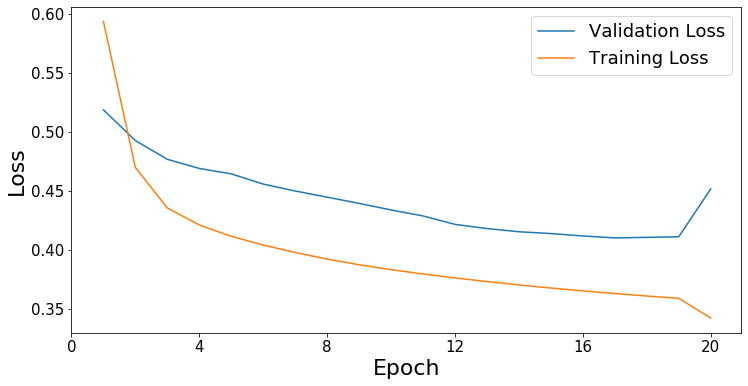

In [6]:
fig = plt.figure(figsize=(12,6))
plt.plot(np.arange(20)+1, val_loss, label='Validation Loss')
plt.plot(np.arange(20)+1, tra_loss, label='Training Loss')
plt.xticks(ticks=np.arange(6)*4, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Loss', fontsize=22)
plt.legend(fontsize=18);
plt.savefig('loss_process.png', dpi=500, bbox_inches='tight')